# Model generation without the kv cache

Let's see if we can get the code to work with turning the kv cache off.

How the eigenvaleus be so large if you are using layer norm? In fact, the evals are large BECAUSE we are using RMSNorm

In [68]:
import os
import gc
import time
import json
import pickle
import numpy as np

import torch
import jax
import equinox as eqx
import jax.numpy as jnp
import jax.tree_util as jtu

from functools import partial
from equinox._misc import default_floating_dtype
from jaxtyping import Array, Float, Scalar
from typing import Optional, Tuple, List, NamedTuple

from sentencepiece import SentencePieceProcessor

import pdb
import matplotlib.pyplot as plt

In [2]:
jax.config.update("jax_debug_nans", True)

In [3]:
# Set device to CPU for torch
device  = torch.device("cpu")

In [4]:
# Load the model dict, and check if any GPU is used
# state_dict = torch.load("mistral-7B-v0.1/consolidated.00.pth")
# why is this so much faster on our computer??
state_dict = torch.load(
    "/Users/xaviergonzalez/Desktop/xavier_folders/stanford/cs229s/mistral_jax/model_files/consolidated.00.pth"
)

/var/folders/tf/ybkfqmld4yb8_yn2xr11sl8m0000gn/T/ipykernel_21551/2163712912.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(


# 1. Tokenizer

In [5]:
class Tokenizer:
    def __init__(self, model_path: str):
        self._model = SentencePieceProcessor(model_file=model_path)

    @property
    def eos_id(self) -> int:
        return self._model.eos_id()

    @property
    def pad_id(self) -> int:
        return self._model.pad_id()

    def encode(self, s: str) -> List[int]:
        return [self._model.bos_id(), *self._model.encode(s)]

    def decode(self, t: List[int]) -> str:
        return self._model.decode(t)

# 2. RoPE

In [6]:
def precompute_frequencies(dim, max_pos, theta=10000.0):
    inv_freq = 1.0 / (
        theta ** (jnp.arange(0, dim, 2, dtype=jnp.float32)[: (dim // 2)] / dim)
    )
    t = jnp.arange(0, max_pos, dtype=jnp.float32)
    freqs = jnp.outer(t, inv_freq)
    return jnp.cos(freqs), jnp.sin(freqs)


@partial(jax.jit, static_argnums=(3,))
def calculate_rope(x, cos_freq, sin_freq, offset=0):
    # x shape  is [seqlen, num_heads, heads_dim]

    # Get the sequence length
    seqlen = x.shape[0]

    # Get the corresponding positional embeddings
    sin = sin_freq[offset : offset + seqlen, :]
    cos = cos_freq[offset : offset + seqlen, :]

    # Positional embeddings are 2D while our input is 3D
    # if `num_heads` dimension is present in the inputs.
    # We need to add another dimension to our positional embeddings
    sin = sin[:, jnp.newaxis, :]
    cos = cos[:, jnp.newaxis, :]

    # Get the even-odd positions from the inputs
    x1 = x[..., 0::2]
    x2 = x[..., 1::2]

    # Matmul with the rotation matrix
    # [cos_nθ, -sin_nθ] [x1]
    # [sin_nθ,  cos_nθ] [x2]
    # => [x1 * cos_nθ - x2 * sin_nθ, x1 * sin_nθ + x2 * cos_nθ]
    pos_embed = jnp.stack([x1 * cos - x2 * sin, x1 * sin + x2 * cos], axis=-1)
    pos_embed = jax.lax.collapse(pos_embed, -2)
    return pos_embed.astype(x.dtype)

# 3. RMSNorm

In [ ]:
class RMSNorm(eqx.Module):
    """
    Make the root mean square of the output to be 1.
    """
    eps: float
    weight: Float[Array, "*shape"]

    def __init__(self, dim, eps, dtype=jnp.bfloat16):
        dtype = default_floating_dtype if dtype is None else dtype
        self.eps = eps
        self.weight = jnp.ones(shape=dim, dtype=dtype)

    def rmsnorm(self, x):
        return jnp.sqrt(jnp.mean(x**2, keepdims=True) + self.eps)

    def _norm(self, x):
        return x * jax.lax.rsqrt(jnp.mean(x **2 , keepdims=True) + self.eps)

    def __call__(self, x):
        output = self._norm(x.astype(jnp.float32)).astype(x.dtype)
        return output * self.weight

# 4. FeedForward

In [8]:
class FeedForward(eqx.Module):
    w1: eqx.nn.Linear
    w2: eqx.nn.Linear
    w3: eqx.nn.Linear

    def __init__(self, args, key, dtype=jnp.bfloat16):
        dtype = default_floating_dtype if dtype is None else dtype
        key1, key2, key3 = jax.random.split(key, 3)

        self.w1 = eqx.nn.Linear(args.dim, args.hidden_dim, use_bias=False, key=key1, dtype=dtype)
        self.w2 = eqx.nn.Linear(args.hidden_dim, args.dim, use_bias=False, key=key2, dtype=dtype)
        self.w3 = eqx.nn.Linear(args.dim, args.hidden_dim, use_bias=False, key=key3, dtype=dtype)

    def __call__(self, x):
        h = jax.nn.silu(self.w1(x).astype(jnp.float32)).astype(x.dtype)
        return self.w2(h * self.w3(x))

# 5. Attention

In [9]:
class Attention(eqx.Module):
    dim: int
    n_heads: int
    head_dim: int
    n_kv_heads: int
    kv_repeats: int
    sliding_window: int
    scale: float
    wq: eqx.nn.Linear
    wk: eqx.nn.Linear
    wv: eqx.nn.Linear
    wo: eqx.nn.Linear

    def __init__(self, args, key, dtype=jnp.bfloat16):
        dtype = default_floating_dtype if dtype is None else dtype
        key1, key2, key3, key4 = jax.random.split(key, 4)

        self.n_heads = args.n_heads
        self.head_dim = args.head_dim
        self.n_kv_heads = args.n_kv_heads
        self.dim = args.dim
        self.kv_repeats = self.n_heads // self.n_kv_heads
        self.sliding_window = args.sliding_window

        self.scale = args.head_dim**-0.5

        self.wq = eqx.nn.Linear(args.dim, args.n_heads * args.head_dim, use_bias=False, key=key1, dtype=dtype)
        self.wk = eqx.nn.Linear(args.dim, args.n_kv_heads * args.head_dim, use_bias=False, key=key2, dtype=dtype)
        self.wv = eqx.nn.Linear(args.dim, args.n_kv_heads * args.head_dim, use_bias=False, key=key3, dtype=dtype)
        self.wo = eqx.nn.Linear(args.n_heads * args.head_dim, args.dim, use_bias=False, key=key4, dtype=dtype)

    @partial(jax.jit, static_argnums=(2, 3))
    def get_cache_slice(self, x, pos, kv_repeats):
        x_slice = x.at[:pos, :, :].get()
        x_slice = jnp.repeat(x_slice, kv_repeats, axis=1)
        return x_slice

    @eqx.filter_jit
    def compute_qkv(self, x):
        seqlen, _ = x.shape

        xq = jax.vmap(self.wq)(x)
        xk = jax.vmap(self.wk)(x)
        xv = jax.vmap(self.wv)(x)

        xq = jnp.reshape(xq, (seqlen, self.n_heads, self.head_dim))
        xk = jnp.reshape(xk, (seqlen, self.n_kv_heads, self.head_dim))
        xv = jnp.reshape(xv, (seqlen, self.n_kv_heads, self.head_dim))
        return xq, xk, xv

    @jax.jit
    def update_cache_values(self, xk, xv, cache_k, cache_v, positions):
        cache_k = cache_k.at[positions, ...].set(xk[positions, ...])
        cache_v = cache_v.at[positions, ...].set(xv[positions, ...])
        return cache_k, cache_v

    @eqx.filter_jit
    def prefill(self, xk, xv):
        key = jnp.repeat(xk, self.kv_repeats, axis=1)
        value = jnp.repeat(xv, self.kv_repeats, axis=1)
        return key, value

    @eqx.filter_jit
    def compute_scores_and_output(self, xq, key, value, mask, seqlen):
        query = jnp.transpose(xq, (1, 0, 2))
        key = jnp.transpose(key, (1, 0, 2))
        value = jnp.transpose(value, (1, 0, 2))

        # # # scores : [n_heads, seqlen | 1, seqlen]
        scores = jnp.matmul(query, jnp.transpose(key, (0, 2, 1))) * self.scale

        if mask is not None:
            # Mask will of shape [seqlen, seqlen] but our scores
            # have shape [num_heads, seqlen, seqlen], hence we need
            # to introduce another dimension in the mask
            mask = mask[jnp.newaxis, ...]
            scores = scores + mask

        scores = jax.nn.softmax(scores.astype(jnp.float32), axis=-1).astype(query.dtype)
        output = jnp.matmul(scores, value)
        output = jnp.reshape(jnp.transpose(output, (1, 0, 2)), (seqlen, -1))
        output = jax.vmap(self.wo)(output)
        return output

    def __call__(self,  x, cos_freq, sin_freq, positions, mask=None, cache_k=None, cache_v=None):
        # x shape: [seqlen, embed_dim]
        seqlen, _ = x.shape
        # 1. Calculate qkv
        xq, xk, xv = self.compute_qkv(x)

        # 2. Calculate RoPE
        xq = calculate_rope(xq, cos_freq, sin_freq, 0)
        xk = calculate_rope(xk, cos_freq, sin_freq, 0)

        key, value = self.prefill(xk, xv)

        # # 3. Update cache
        # cache_k, cache_v = self.update_cache_values(xk, xv, cache_k, cache_v, positions)

        # # 4. Generation
        # if positions.shape[0] > 1:
        #     # prefill
        #     key, value = self.prefill(xk, xv)
        # else:
        #     # single-token generation
        #     cur_pos = positions[-1].item() + 1
        #     key = self.get_cache_slice(cache_k, cur_pos, self.kv_repeats)
        #     value = self.get_cache_slice(cache_v, cur_pos, self.kv_repeats)

        # 5. Output
        output = self.compute_scores_and_output(xq, key, value, mask, seqlen)
        # return output, cache_k, cache_v
        return output

# 6. TransformerBlock

In [10]:
class TransformerBlock(eqx.Module):
    dim: int
    n_heads: int
    attention: Attention
    attention_norm: RMSNorm
    feed_forward: FeedForward
    ffn_norm: RMSNorm

    def __init__(self, args, key, dtype=jnp.bfloat16):
        key1, key2 = jax.random.split(key, 2)
        self.n_heads = args.n_heads
        self.dim = args.dim

        self.attention = Attention(args, key=key1, dtype=dtype)
        self.attention_norm = RMSNorm(args.dim, eps=args.norm_eps, dtype=dtype)

        self.feed_forward = FeedForward(args, key=key2, dtype=dtype)
        self.ffn_norm = RMSNorm(args.dim, eps=args.norm_eps, dtype=dtype)

    # def __call__(self, x, cos_freq, sin_freq, positions, mask, cache_k, cache_v):
    def __call__(self, x, cos_freq, sin_freq, positions, mask):
        normed_x = jax.vmap(self.attention_norm)(x)
        # r, cache_k, cache_v = self.attention(normed_x, cos_freq, sin_freq, positions, mask, cache_k, cache_v)
        r = self.attention(
            normed_x, cos_freq, sin_freq, positions, mask
        )
        h = x + r
        r = jax.vmap(self.feed_forward)(jax.vmap(self.ffn_norm)(h))
        out = h + r
        return out
        # return out, cache_k, cache_v

# 7. Transformer

In [53]:
class Transformer(eqx.Module):
    tok_embeddings: eqx.nn.Embedding
    layers: TransformerBlock
    norm: RMSNorm
    output: eqx.nn.Linear
    vocab_size: int
    n_layers: int
    sliding_window: int

    def __init__(self, args, key, dtype=jnp.bfloat16):
        self.vocab_size = args.vocab_size
        self.n_layers = args.n_layers
        self.sliding_window = args.sliding_window
        keys = jax.random.split(key, args.n_layers + 2)
        embed_key, linear_key, tf_layers_keys = keys[0], keys[1], keys[2:]

        self.tok_embeddings = eqx.nn.Embedding(args.vocab_size, args.dim, key=embed_key, dtype=dtype)
        self.norm = RMSNorm(dim=args.dim, eps=args.norm_eps, dtype=dtype)
        self.output = eqx.nn.Linear(args.dim, args.vocab_size, use_bias=False, key=linear_key, dtype=dtype)
        self.layers = [TransformerBlock(args, key=tf_layers_keys[i], dtype=dtype) for i in range(args.n_layers)] 

    @eqx.filter_jit
    def compute_embeddings(self, x):
        return jax.vmap(self.tok_embeddings)(x)

    @eqx.filter_jit
    def compute_mask(self, seqlen):
        t = jnp.full((seqlen, seqlen), dtype=jnp.bfloat16, fill_value=1)
        mask = jnp.tril(t, k=0)
        # make the mask banded to account for sliding window
        mask = jnp.triu(mask, k=-self.sliding_window)
        mask = jnp.log(mask)
        return mask

    @eqx.filter_jit
    def compute_norm(self, x):
        return jax.vmap(self.norm)(x)

    @eqx.filter_jit
    def compute_output(self, x):
        return jax.vmap(self.output)(x)

    @partial(jax.jit, static_argnums=(1,))
    def update_cache_values(self, idx, cache_k, cache_v, cache_k_updates, cache_v_updates):
        cache_k = cache_k.at[idx, :, :, :].set(cache_k_updates)
        cache_v = cache_v.at[idx, :, :, :].set(cache_v_updates)
        return cache_k, cache_v

    # def __call__(self, x, cos_freq, sin_freq, positions, mask, cache_k, cache_v):
    #     # x is of shape (seqlen, )
    #     h = self.compute_embeddings(x)

    #     if x.shape[-1] > 1:
    #         seqlen = x.shape[-1]
    #         mask = self.compute_mask(seqlen)
    #     else:
    #         mask = None

    #     # the for loop!!!

    #     for i, layer in enumerate(self.layers):
    #         #pdb.set_trace()
    #         # h has shape (len(positions), dim)
    #         # cache_ki has shape (sliding_window_len, head_dim, n_kv_heads)
    #         h, cache_ki, cache_vi = layer(h, cos_freq, sin_freq, positions, mask, cache_k[i, ...], cache_v[i, ...]) # I think we could get away with creating blank entries for h, cache_ki, and cache_vi
    #         # pdb.set_trace()
    #         cache_k, cache_v = self.update_cache_values(i, cache_k, cache_v, cache_ki, cache_vi) # I think all this line is doing is plugging in cache_ki and cache_vi in the appropriate palce

    #     h = self.compute_norm(h)
    #     h = self.compute_output(h).astype(jnp.float32)
    #     return h, cache_k, cache_v

    def __call__(self, x, cos_freq, sin_freq, positions, mask):
        """
        Edited to do prefilling instead of kv cache
        """
        # x is of shape (seqlen, )
        h = self.compute_embeddings(x)

        if x.shape[-1] > 1:
            seqlen = x.shape[-1]
            mask = self.compute_mask(seqlen)
        else:
            mask = None

        all_states = []
        for i, layer in enumerate(self.layers):
            # h has shape (len(positions), dim)
            # cache_ki has shape (sliding_window_len, head_dim, n_kv_heads)
            h = layer(h, cos_freq, sin_freq, positions, mask) # h has shape (T,D)
            all_states.append(h)
            # print(f"at layer {i}, the shape of the feature is {h.shape}")

        # h = self.compute_norm(h)
        # h = self.compute_output(h).astype(jnp.float32)
        return jnp.array(all_states)

    def partial_layers(self, layers, cos_freq, sin_freq, positions, mask):
        """
        Ideally we could use jtu instead...
        """
        def partial_layer(layer):
            return partial(layer.__call__, cos_freq=cos_freq, sin_freq=sin_freq, positions=positions, mask=mask)

        return [partial_layer(layer) for layer in layers] # really would prefer not to use list comprehension

    def parallel_call(self, x, cos_freq, sin_freq, positions, mask, num_iters=7):
        """
        Should give the same output as call, but using fixed point iterations
        """
        h0 = self.compute_embeddings(x)
        T, D = h0.shape

        if x.shape[-1] > 1:
            seqlen = x.shape[-1]
            mask = self.compute_mask(seqlen)
        else:
            mask = None

        # parallel logic
        num_layers = len(self.layers)
        # pdb.set_trace()
        partialed_layers = self.partial_layers(self.layers, cos_freq, sin_freq, positions, mask)
        states_guess = [
            jnp.ones((T, D)) for _ in range(num_layers)
        ]  # make sure to stay near rms norm equal to 1
        # states_guess = [jnp.zeros((T, D)) for _ in range(num_layers)] # never do this when using rms norm, grads will explode
        # calls out to deer
        all_states = deer(h0, partialed_layers, states_guess, num_iters) # (batch_size, num_iters, num_layers, T, D)

        return jnp.array(all_states)
        # h = all_states[-1][-1]
        # pdb.set_trace()

        # h = self.compute_norm(h)
        # h = self.compute_output(h).astype(jnp.float32)
        # return h


def deer(x, layers, states_guess, num_iters, k =1):
    """
    runs deer (fiddly logic in the rearrange)

    Args:
      x: (T, d) initial inputs to transformer stack
      layers: list of TransformerLayer objects (the functions that propagate information over the stack)
      states_guess: list of length num_layers of (T, D) shaped arrays; this is the initial guess for the states. don't make them all zero!
      num_iters: number of iterations to run for
      k: damping factor
    """
    T, D = x.shape
    num_layers = len(layers)

    @jax.vmap
    def binary_op(q_i, q_j):
        """Binary operator for parallel scan of linear recurrence. Assumes a full Jacobian matrix A
        Args:
            q_i: tuple containing J_i and b_i at position i       (P,P), (P,)
            q_j: tuple containing J_j and b_j at position j       (P,P), (P,)
        Returns:
            new element ( A_out, Bu_out )
        """
        A_i, b_i = q_i
        A_j, b_j = q_j
        return A_j @ A_i, A_j @ b_i + b_j

    def step(states, args):
        """
        This step is a single deer iteration (will eventually be sequential scanned)
        Args:
          states: list of length num_layers of (T, D) shaped arrays
          args: None
        """
        states = [x] + states[:-1]  # length num_layers
        print(f"states shape is {states[0].shape}")
        fs = jnp.array(
            jtu.tree_map(lambda x, f: f(x), states, layers)
        )  # (num_layers, T,D) arrays, note that we keep states as a list so we can use jtu.tree_map
        print(f"fs shape is {fs.shape}")
        As = jnp.array(
            jtu.tree_map(lambda x, f: jax.jacrev(f)(x), states, layers) # this line seems to be the bottleneck, but that's odd bc we'd expect someone to take this grads during backprop
        )  # (num_layers, T, D, T, D) tensors
        print(f"As shape is {As.shape}")
        As = As.at[0].set(jnp.zeros((T, D, T, D)))
        # pdb.set_trace()
        # need to make the first A equal to zero
        states = jnp.array(states)  # (num_layers, T,D)
        # do some rearranging
        print("starting the rearranges")
        flattened_states = jnp.reshape(states, (num_layers, T * D))  # (num_layers, T*D)
        flattened_As = jnp.reshape(
            As, (num_layers, T * D, T * D)
        )  # (num_layers, T*D, T*D)
        # somehow, we aren't even getting here
        # print("we are about to start computing eigenvalues")
        # for A in flattened_As:
        #     print(jnp.linalg.eigvals(A))
        # pdb.set_trace()
        flattened_fs = jnp.reshape(fs, (num_layers, T * D))  # (num_layers, T*D)
        bs = flattened_fs - jnp.einsum(
            "tij,tj->ti", flattened_As, flattened_states
        )  # (num_layers, T*D)

        # finally ready to evaluate linearized dynamics (in parallel)
        print("we are about to start the associative scan")
        _, new_states = jax.lax.associative_scan(
            binary_op, (flattened_As, bs)
        )  # parallel operation
        # new_states = jnp.nan_to_num(new_states)  # zero out nans, (num_layers, T*D)
        new_states = jnp.reshape(new_states, (num_layers, T, D))  # (num_layers, T, D)
        return list(new_states), new_states

    print("starting deer outer loop")
    # states_guess, iter_hist = jax.lax.scan(
    #     step, states_guess, None, length=num_iters
    # )  # state_iters will show all the intermediate traces

    iter_hist = []
    for i in range(num_iters):
        print()
        print("-----------------")
        print(f"iteration {i}")
        print("-----------------")
        print()
        states_guess, iter_hist_add = step(states_guess, None)
        iter_hist.append(iter_hist_add)

    # return states_guess
    return jnp.array(iter_hist) # (num_iters, num_layers, T, D)

In [48]:
class ModelArgs(NamedTuple):
    dim: int
    n_layers: int
    n_heads: int
    n_kv_heads: int
    head_dim: int
    hidden_dim: int
    vocab_size: int
    sliding_window: int
    norm_eps: float
    max_batch_size: int = 1

# maybe we could do a proto_params.json, and just not load in the weights
with open(
    "/Users/xaviergonzalez/Desktop/xavier_folders/stanford/cs229s/mistral_jax/model_files/params.json",
    "r",
) as f:
    #with open('./mistral-7B-v0.1/params.json', 'r') as f:
    args = ModelArgs(**json.loads(f.read()))

In [20]:
def port_weights_from_torch(torch_weights, eqx_model):
    def load_weights(path, leaf):
        path_pieces = []
        for path_elem in path:
            if isinstance(path_elem, jax.tree_util.GetAttrKey):
                 path_pieces.append(path_elem.name)
            elif isinstance(path_elem, jax.tree_util.SequenceKey):
                 path_pieces.append(str(path_elem.idx))
            else:
                raise ValueError(f"Unsupported path type {type(path_elem)}")

        path_pieces = ".".join(path_pieces)
        
        if "weight" in path_pieces:
            weight = torch_weights[path_pieces]
            weight = jnp.asarray(weight.float().numpy(), dtype=jnp.bfloat16)
            assert weight.shape == leaf.shape
            assert weight.dtype == leaf.dtype
            return weight
        else:
            print(f"Weights not ported for: {path_pieces}")
            return leaf

    return jax.tree_util.tree_map_with_path(load_weights, eqx_model)

In [54]:
model = Transformer(args, key=jax.random.PRNGKey(1), dtype=jnp.bfloat16) # sets architecutre
model = port_weights_from_torch(state_dict, model) # fills with pretrained weights

Weights not ported for: layers.0.dim
Weights not ported for: layers.0.n_heads
Weights not ported for: layers.0.attention.dim
Weights not ported for: layers.0.attention.n_heads
Weights not ported for: layers.0.attention.head_dim
Weights not ported for: layers.0.attention.n_kv_heads
Weights not ported for: layers.0.attention.kv_repeats
Weights not ported for: layers.0.attention.sliding_window
Weights not ported for: layers.0.attention.scale
Weights not ported for: layers.0.attention_norm.eps
Weights not ported for: layers.0.ffn_norm.eps
Weights not ported for: layers.1.dim
Weights not ported for: layers.1.n_heads
Weights not ported for: layers.1.attention.dim
Weights not ported for: layers.1.attention.n_heads
Weights not ported for: layers.1.attention.head_dim
Weights not ported for: layers.1.attention.n_kv_heads
Weights not ported for: layers.1.attention.kv_repeats
Weights not ported for: layers.1.attention.sliding_window
Weights not ported for: layers.1.attention.scale
Weights not port

In [77]:
# cache_k = jnp.zeros((args.max_batch_size, args.n_layers, args.sliding_window, args.n_kv_heads, args.head_dim), dtype=jnp.bfloat16)
# cache_v = jnp.zeros((args.max_batch_size, args.n_layers, args.sliding_window, args.n_kv_heads, args.head_dim), dtype=jnp.bfloat16)
NUM_ITERS = 4
cos_freq, sin_freq = precompute_frequencies(args.head_dim, 128000)
vmapped = jax.vmap(partial(model.parallel_call, num_iters=NUM_ITERS), in_axes=(0, None, None, None, None)) # vmapped is the name of the model

In [55]:
vmap_seq = jax.vmap(
    model,
    in_axes=(0, None, None, None, None),
)  # vmapped is the name of the model

In [78]:
fake_pos = jnp.array([0], dtype=jnp.int32)
fake_inp = jnp.asarray([[1]], dtype=jnp.int32)
fake_mask = None

hist_seq = vmap_seq(
    fake_inp, cos_freq[fake_pos], sin_freq[fake_pos], fake_pos, fake_mask
)
hist_parr = vmapped(fake_inp, cos_freq[fake_pos], sin_freq[fake_pos], fake_pos, fake_mask)
jnp.save(f"parallel_history_NumIters_{NUM_ITERS}.npy", hist_parr)

starting deer outer loop

-----------------
iteration 0
-----------------

states shape is (1, 4096)
fs shape is (32, 1, 4096)
As shape is (32, 1, 4096, 1, 4096)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 1
-----------------

states shape is (1, 4096)
fs shape is (32, 1, 4096)
As shape is (32, 1, 4096, 1, 4096)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 2
-----------------

states shape is (1, 4096)
fs shape is (32, 1, 4096)
As shape is (32, 1, 4096, 1, 4096)
starting the rearranges
we are about to start the associative scan

-----------------
iteration 3
-----------------

states shape is (1, 4096)
fs shape is (32, 1, 4096)
As shape is (32, 1, 4096, 1, 4096)
starting the rearranges
we are about to start the associative scan


In [25]:
jnp.load("logits.npy").shape

(1, 32, 1, 4096)

In [57]:
logits.shape

(1, 2, 32, 1, 4096)

In [59]:
hist_seq.shape

(1, 32, 1, 4096)

In [ ]:
errors_per_iter_and_layer = jnp.mean(jnp.abs((hist_parr[0] - hist_seq).squeeze()), axis=-1)
print(jnp.shape(errors_per_iter_and_layer))

(2, 32)


In [75]:
errors_per_iter_and_layer

Array([[0.0000000e+00, 1.9379653e-01, 1.9577831e-01, 1.9842212e-01,
        2.0143938e-01, 2.0685999e-01, 2.1126443e-01, 2.1645682e-01,
        2.2188202e-01, 2.2748125e-01, 2.3476216e-01, 2.4526620e-01,
        2.5457206e-01, 2.6582250e-01, 2.8100759e-01, 2.9988283e-01,
        3.1659949e-01, 3.3331496e-01, 3.5449558e-01, 3.7569577e-01,
        3.9936203e-01, 4.2514843e-01, 4.4629109e-01, 4.7540399e-01,
        5.1046073e-01, 5.4050022e-01, 5.7685274e-01, 6.0469234e-01,
        6.3749349e-01, 7.1767086e-01, 8.5089880e-01, 2.8431191e+00],
       [0.0000000e+00, 5.0305593e-04, 6.0457230e-02, 1.3351017e-01,
        2.5135112e-01, 4.1541496e-01, 6.3431966e-01, 9.3786740e-01,
        1.2459170e+00, 1.5389332e+00, 1.8103627e+00, 2.0912023e+00,
        2.3293934e+00, 2.5727761e+00, 2.8292270e+00, 3.0645685e+00,
        3.3717854e+00, 3.6113937e+00, 3.8956900e+00, 4.2682900e+00,
        4.6444583e+00, 5.0535717e+00, 5.3322926e+00, 5.7752161e+00,
        6.2550097e+00, 6.7042480e+00, 7.0214586

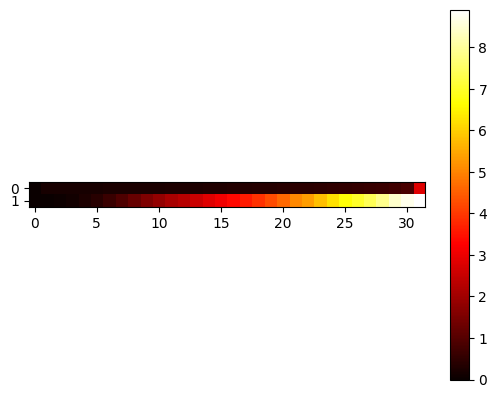

In [76]:
plt.imshow(errors_per_iter_and_layer, cmap="hot", interpolation="nearest")
plt.colorbar()

In [ ]:
model.compute_norm

In [28]:
logits

Array([[[[[-8.92639160e-04,  2.65502930e-03, -1.84570312e-01, ...,
            7.62939453e-06, -1.43432617e-03, -1.95312500e-03]],

         [[-8.91094469e-03, -6.18494023e-03, -1.85622007e-01, ...,
            9.09190509e-04, -5.82782552e-03, -1.42973997e-02]],

         [[-6.07582554e-03, -3.72581817e-02, -1.96056485e-01, ...,
           -2.17162538e-02, -3.14874249e-03, -9.00264457e-03]],

         ...,

         [[ 1.10669410e+00,  1.49299145e-01, -5.95834732e-01, ...,
            3.55023921e-01,  1.29173613e+00, -5.56365788e-01]],

         [[ 1.05325460e+00,  1.63162947e-02, -5.39088607e-01, ...,
            5.94611347e-01,  1.15215635e+00, -6.52567387e-01]],

         [[ 4.23761547e-01,  2.28124112e-01, -1.06671560e+00, ...,
            5.91840267e-01,  8.96652579e-01, -7.07928896e-01]]],


        [[[-8.92639160e-04,  2.65502930e-03, -1.84570312e-01, ...,
            7.62939453e-06, -1.43432617e-03, -1.95312500e-03]],

         [[-1.20094955e-01, -3.91652256e-01, -1.39715612e-0

In [31]:
fake_inp_flat = jnp.asarray([1, 832, 349, 265, 1369], dtype=jnp.int32)

In [ ]:
model(fake_inp_flat, cos_freq[fake_pos], sin_freq[fake_pos], fake_pos, fake_mask)

Array([[-5.84375   , -5.8125    , -0.09960938, ..., -4.3125    ,
        -3.515625  , -4.03125   ],
       [-8.875     , -8.8125    ,  0.39257812, ..., -6.4375    ,
        -6.6875    , -7.15625   ],
       [-7.09375   , -6.875     , -0.8359375 , ..., -6.96875   ,
        -5.4375    , -4.59375   ],
       [-7.03125   , -7.03125   ,  0.75      , ..., -5.75      ,
        -7.625     , -5.75      ],
       [-7.46875   , -7.53125   ,  0.73828125, ..., -7.1875    ,
        -7.65625   , -5.75      ]], dtype=float32)

In [33]:
type(model.norm)

__main__.RMSNorm

In [34]:
jnp.sqrt(jnp.mean(logits[0, -1, 0] ** 2))

Array(0.0936636, dtype=float32)

In [35]:
jnp.sqrt(jnp.mean(model.norm(logits[0, -1, 0]) ** 2))

Array(5.442458, dtype=float32)

In [36]:
fake_inp_flat = jnp.asarray([1, 832, 349, 265, 1369], dtype=jnp.int32)

In [37]:
attn = Attention(args, key=jax.random.PRNGKey(1), dtype=jnp.bfloat16)

In [38]:
cos_freq.shape

(128000, 64)

In [39]:
model.compute_embeddings(fake_inp_flat).shape # (T, D)

(5, 4096)

In [40]:
x.shape[0]

NameError: name 'x' is not defined

In [ ]:
x = model.compute_embeddings(fake_inp_flat)
xq, xk, xv = attn.compute_qkv(x)
key, value = attn.prefill(xk, xv)
output = attn.compute_scores_and_output(xq, key, value, fake_mask, x.shape[0])

In [ ]:
x.shape

(5, 4096)

In [ ]:
output.shape

(5, 4096)

In [ ]:
xk.shape

(5, 8, 128)

In [ ]:
xq.shape

(5, 32, 128)

In [ ]:
key.shape

(5, 32, 128)

In [ ]:
value.shape

(5, 32, 128)

In [ ]:
xq.shape # (T, n_heads, head_dim)

(5, 32, 128)

In [ ]:
xk.shape # (T, n_kv_heads, head_dim)

(5, 8, 128)

In [ ]:
xv.shape # (T, n_kv_heads, head_dim)

(5, 8, 128)

In [ ]:
attn.compute_scores_and_output(xq, xk, xv, fake_mask, 5).shape # (T, D)

In [ ]:
fake_pos.shape[0]

5

In [ ]:
attn(model.compute_embeddings(fake_inp_flat), cos_freq[:5], sin_freq[:5], fake_pos)

AttributeError: 'NoneType' object has no attribute 'at'

In [ ]:
jax.vmap(model.compute_embeddings)(fake_inp).shape

(1, 5, 4096)

In [ ]:
logits.shape # (batch, T, V)

(1, 5, 32000)

In [ ]:
model(
    fake_inp,
    cos_freq[fake_pos],
    sin_freq[fake_pos],
    fake_pos,
    fake_mask,
    cache_k,
    cache_v,
)

ValueError: `eqx.nn.Embedding()(x)` should be called with a scalar index `x`. Use `jax.vmap` if you would like to index with multiple values.

In [ ]:
%debug

> /Users/xaviergonzalez/opt/anaconda3/envs/mistral-eqx/lib/python3.12/site-packages/equinox/nn/_embedding.py(101)__call__()
     99             return self.weight[x]
    100         else:
--> 101             raise ValueError(
    102                 "`eqx.nn.Embedding()(x)` should be called with a scalar index `x`. "
    103                 "Use `jax.vmap` if you would like to index with multiple values."

> /Users/xaviergonzalez/opt/anaconda3/envs/mistral-eqx/lib/python3.12/contextlib.py(81)inner()
     79         def inner(*args, **kwds):
     80             with self._recreate_cm():
---> 81                 return func(*args, **kwds)
     82         return inner
     83 

> /var/folders/tf/ybkfqmld4yb8_yn2xr11sl8m0000gn/T/ipykernel_2338/467368851.py(24)compute_embeddings()
     22     @eqx.filter_jit
     23     def compute_embeddings(self, x):
---> 24         return jax.vmap(self.tok_embeddings)(x)
     25 
     26     @eqx.filter_jit

    [... skipped 3 hidden frame(s)]

(1, 5)
***